# [Pyro](https://python-hydro.github.io/pyro2/) tutorial

Mike Zingale wrote a pedagogical library describing some of the numerical methods often found in astrophysical hydrodynamics called [pyro](https://python-hydro.github.io/pyro2/).
You can fin the code [on github](https://github.com/python-hydro/pyro2).



In [14]:
from pyro import Pyro

In [15]:
solver = "compressible"
problem_name = "sod"
param_file = "inputs.sod.x"
pyro_sim = Pyro(solver)
extra_parameters = {'vis.dovis': False, 'mesh.nx': 128, 'mesh.ny':4, 'particles.do_particles': False, "eos.gamma":1.01}
pyro_sim.initialize_problem(problem_name, inputs_file=param_file, inputs_dict=extra_parameters)

In [16]:
print(pyro_sim)

Solver = compressible
Problem = sod
Simulation time = 0.0
Simulation step number = 0

Runtime Parameters
------------------
compressible.cvisc = 0.1
compressible.delta = 0.33
compressible.grav = 0.0
compressible.limiter = 1
compressible.riemann = HLLC
compressible.use_flattening = 1
compressible.z0 = 0.75
compressible.z1 = 0.85
driver.cfl = 0.8
driver.fix_dt = -1.0
driver.init_tstep_factor = 0.01
driver.max_dt_change = 2.0
driver.max_steps = 200
driver.tmax = 0.2
driver.verbose = 0
eos.gamma = 1.01
io.basename = sod_x_
io.do_io = 0
io.dt_out = 0.05
io.force_final_output = 0
io.n_out = 10000
mesh.grid_type = Cartesian2d
mesh.nx = 128
mesh.ny = 4
mesh.xlboundary = outflow
mesh.xmax = 1.0
mesh.xmin = 0.0
mesh.xrboundary = outflow
mesh.ylboundary = reflect
mesh.ymax = 0.05
mesh.ymin = 0.0
mesh.yrboundary = reflect
particles.do_particles = False
particles.n_particles = 100
particles.particle_generator = grid
sod.dens_left = 1.0
sod.dens_right = 0.125
sod.direction = x
sod.p_left = 1.0
sod.p

In [17]:
g = pyro_sim.get_grid()

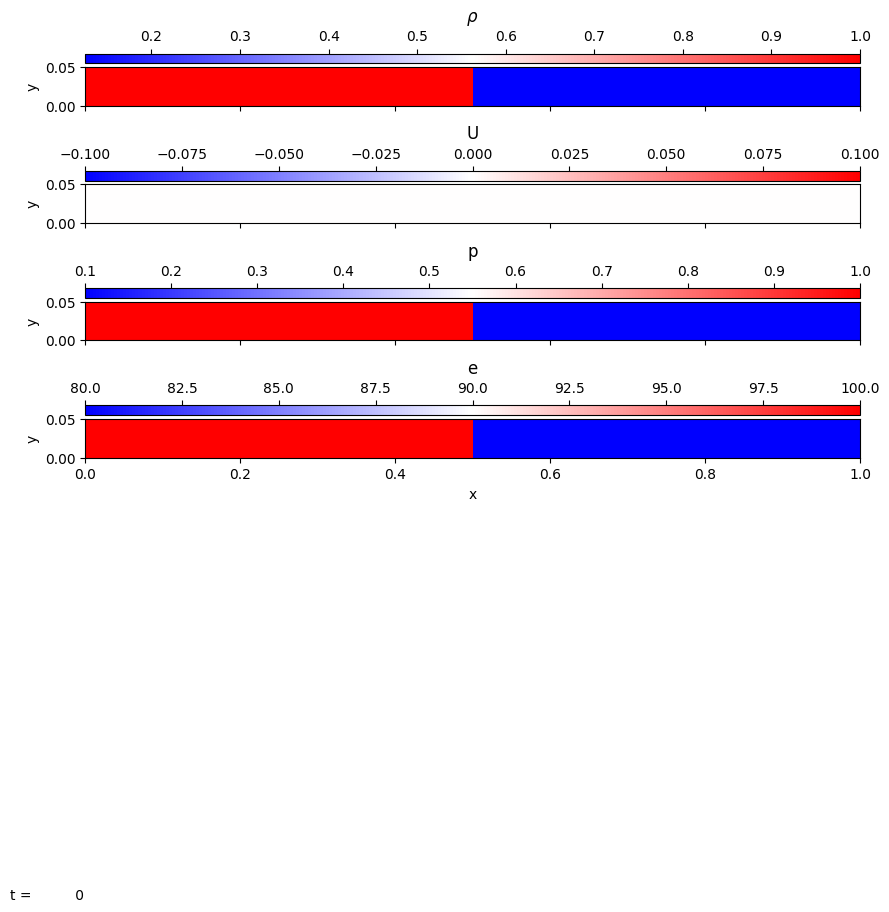

<Figure size 1000x1333.4 with 0 Axes>

In [18]:

import matplotlib.pyplot as plt
# Example: set "bwr" as the default colormap
pyro_sim.sim.cm = 'bwr'
pyro_sim.sim.dovis()

In [19]:
for i in range(10):
    pyro_sim.single_step()

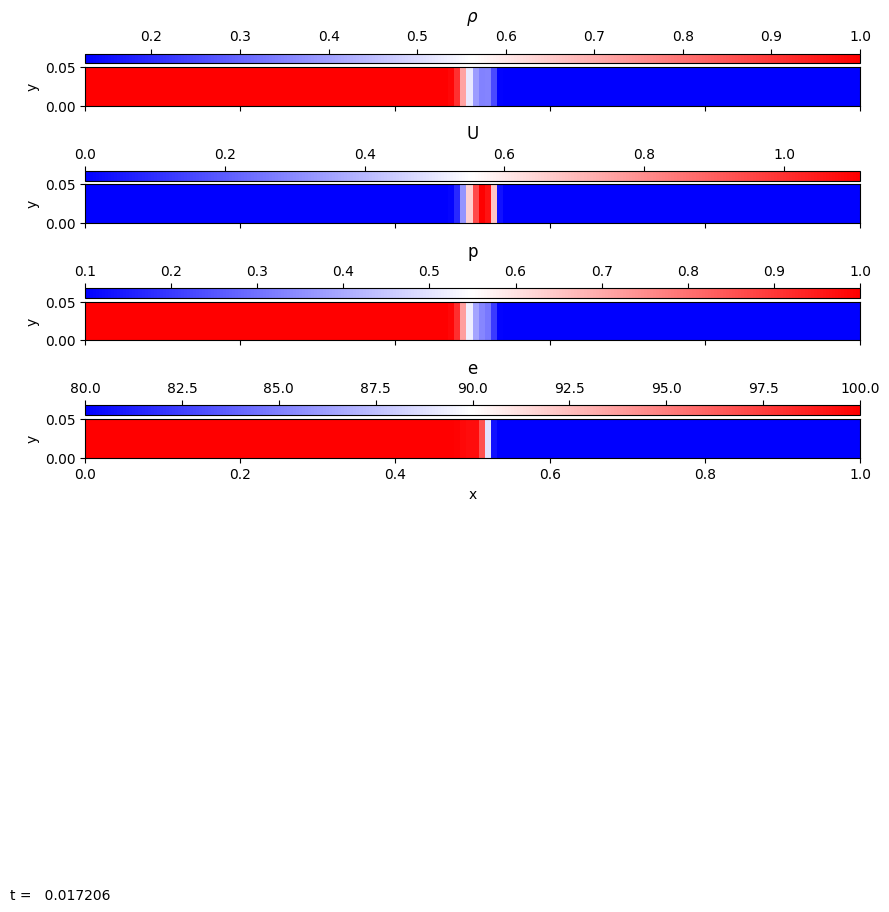

<Figure size 1000x1333.4 with 0 Axes>

In [20]:
pyro_sim.sim.dovis()

In [21]:
import numpy as np
def precompute_shocktube(pyro_sim, ntotal, substeps=10):
    """
    Run 'ntotal' steps of pyro_sim, storing all relevant fields
    in a list so we can animate them later.
    """
    states = np.empty(ntotal, dtype=object)
    for i in range(ntotal):

        # Grab data at this step
        state_data = {
            "density"   : pyro_sim.get_var("density")[:, 4].copy(),
            "x_momentum": pyro_sim.get_var("x-momentum")[:, 4].copy(),
            "pressure"  : pyro_sim.get_var("pressure")[:, 4].copy(),
            "energy"    : pyro_sim.get_var("energy")[:, 4].copy(),
            "x"         : pyro_sim.get_grid().x.copy(),
            "step"      : pyro_sim.sim.n*substeps  # current step number
        }
        states[i] = state_data

        for k in range(substeps):
            pyro_sim.single_step()  # advance by one step
        
    return states


#EOS_GAMMA = 5./3
EOS_GAMMA = 1.001

solver = "compressible"
problem_name = "sod"
param_file = "inputs.sod.x"
pyro_sim = Pyro(solver)
extra_parameters = {"sod.p_left" : 1000.0, "eos.gamma": EOS_GAMMA, 'driver.max_steps':1000, 'driver.tmax':1., 'vis.dovis': False, 'mesh.nx': 256, 'mesh.ny':2, 'particles.do_particles': False}
pyro_sim.initialize_problem(problem_name, inputs_file=param_file, inputs_dict=extra_parameters)

ntotal = 51
states = precompute_shocktube(pyro_sim, ntotal, substeps=4)


In [22]:
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def shocktube_animation_app(states):
    """
    Create an interactive slider + play widget to browse precomputed 'states'.

    Parameters
    ----------
    states : list of dict
        Each element is a dictionary with keys:
         - "density", "x_momentum", "pressure", "energy" (arrays)
         - "x": the spatial coordinate array
         - "step": integer time step index

    Returns
    -------
    ui : widgets.VBox
        A VBox widget containing the slider, play controls, and the plot output.
    """
    # The total number of precomputed states
    ntotal = len(states)

    # 1) Create a slider to pick the index in [0, ntotal-1]
    slider = widgets.IntSlider(value=0, min=0, max=ntotal - 1, step=1,
        description='Step', continuous_update=False)

    # 2) Create a Play widget for auto animation
    play = widgets.Play(value=0, min=0, max=ntotal - 1,
        step=1,interval=200,       # ms between frames
        description="Press play", disabled=False)

    # Link the Play widget and the slider
    widgets.jslink((play, 'value'), (slider, 'value'))
    widgets.jslink((slider, 'value'), (play, 'value'))

    # 3) Create an output area for the Plotly figure
    output_area = widgets.Output()

    def update_plot(change=None):
        """Draw the figure for the current slider value."""
        index = slider.value
        state = states[index]

        with output_area:
            # Extract data
            x          = state["x"]
            step_num   = state["step"]

            # Build the figure
            fig = make_subplots( rows=2, cols=2,
                subplot_titles=["Density", "X-Momentum", "Pressure", "Energy"],
                vertical_spacing=0.09 )

            # 2x2 subplots
            fig.add_trace(go.Scatter(x=x, y=state["density"],    mode='lines+markers'), row=1, col=1)
            fig.add_trace(go.Scatter(x=x, y=state["x_momentum"], mode='lines+markers'), row=1, col=2)
            fig.add_trace(go.Scatter(x=x, y=state["pressure"],   mode='lines+markers'), row=2, col=1)
            fig.add_trace(go.Scatter(x=x, y=state["energy"],     mode='lines+markers'), row=2, col=2)
            fig.update_layout( title=f"Shocktube Data — Step {step_num}",
                showlegend=False, height=500, width=800,
                margin=dict(l=60, r=60, t=60, b=60) )

            # Show with "notebook" renderer so repeated calls don't stack new outputs
            output_area.clear_output(wait=True)
            fig.show("notebook")
            
    # 4) Observe slider changes => call update_plot
    slider.observe(update_plot, names='value')
    # 5) Initial figure
    update_plot()
    # 6) Combine play+slider+figure into a single UI
    controls = widgets.HBox([play, slider])
    ui = widgets.VBox([controls, output_area])

    return ui

In [23]:
# 3) Build the animation app
app = shocktube_animation_app(states)

# 4) Display in Jupyter
display(app)

In [24]:
d = pyro_sim.get_var("density").copy()
d.pretty_print(show_ghost=False)

         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1   0.99998   0.99986   0.99871   0.99364   0.98504   0.97417     0.962   0.94915   0.93598    0.9227   0.90942   0.89621    0.8831   0.87011   0.85727   0.84457   0.83203   0.81965   0.80743   0.79537   0.78348   0.77176   0.76019   0.74879   0.73755   0.72648   0.71556    0.7048    0.6942   0.68375   0.67346   0.66332   0.65333   0.64349   0.63379   0.62424   0.61483   0.60557   0.59644   0.58745    0.5786   0.56988

## 2D examples of [Fluid Instabilities](https://python-hydro.github.io/pyro2/compressible-rt-compare.html)

Here we’ll compare how different compressible solvers perform when run with the same problem setup.

### Rayleigh-Taylor instability




In [25]:
p = Pyro("compressible")
p.initialize_problem("rt")
print(p)

Solver = compressible
Problem = rt
Simulation time = 0.0
Simulation step number = 0

Runtime Parameters
------------------
compressible.cvisc = 0.1
compressible.delta = 0.33
compressible.grav = -1.0
compressible.limiter = 2
compressible.riemann = HLLC
compressible.use_flattening = 1
compressible.z0 = 0.75
compressible.z1 = 0.85
driver.cfl = 0.8
driver.fix_dt = -1.0
driver.init_tstep_factor = 0.01
driver.max_dt_change = 2.0
driver.max_steps = 10000
driver.tmax = 3.0
driver.verbose = 0
eos.gamma = 1.4
io.basename = rt_
io.do_io = 0
io.dt_out = 0.1
io.force_final_output = 0
io.n_out = 100
mesh.grid_type = Cartesian2d
mesh.nx = 64
mesh.ny = 192
mesh.xlboundary = periodic
mesh.xmax = 1.0
mesh.xmin = 0.0
mesh.xrboundary = periodic
mesh.ylboundary = hse
mesh.ymax = 3.0
mesh.ymin = 0.0
mesh.yrboundary = hse
particles.do_particles = 0
particles.n_particles = 100
particles.particle_generator = grid
rt.amp = 0.25
rt.dens1 = 1.0
rt.dens2 = 2.0
rt.p0 = 10.0
rt.sigma = 0.1
sponge.do_sponge = 0
spong

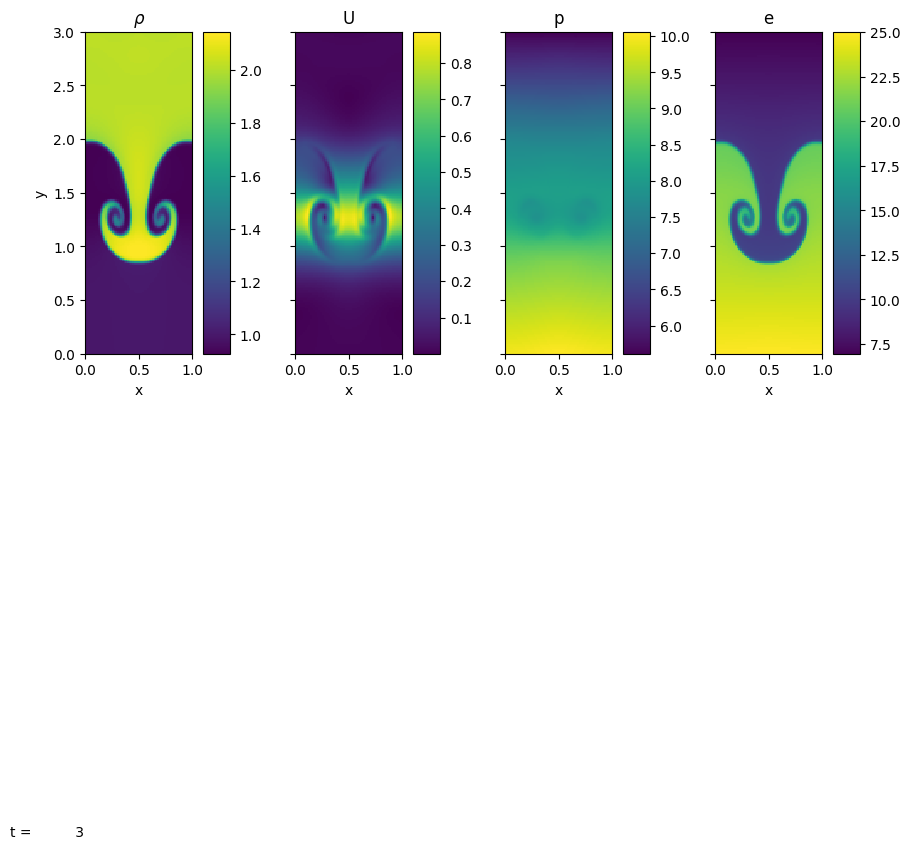

<Figure size 1000x1333.4 with 0 Axes>

In [26]:
p.run_sim()
p.sim.dovis()

In [27]:
p = Pyro("compressible")
p.initialize_problem("kh")
print(p)

Solver = compressible
Problem = kh
Simulation time = 0.0
Simulation step number = 0

Runtime Parameters
------------------
compressible.cvisc = 0.1
compressible.delta = 0.33
compressible.grav = 0.0
compressible.limiter = 2
compressible.riemann = HLLC
compressible.use_flattening = 1
compressible.z0 = 0.75
compressible.z1 = 0.85
driver.cfl = 0.8
driver.fix_dt = -1.0
driver.init_tstep_factor = 0.01
driver.max_dt_change = 2.0
driver.max_steps = 5000
driver.tmax = 2.0
driver.verbose = 0
eos.gamma = 1.4
io.basename = kh_
io.do_io = 0
io.dt_out = 0.1
io.force_final_output = 0
io.n_out = 10000
kh.bulk_velocity = 0.0
kh.rho_1 = 1
kh.rho_2 = 2
kh.u_1 = -0.5
kh.u_2 = 0.5
mesh.grid_type = Cartesian2d
mesh.nx = 64
mesh.ny = 64
mesh.xlboundary = periodic
mesh.xmax = 1.0
mesh.xmin = 0.0
mesh.xrboundary = periodic
mesh.ylboundary = periodic
mesh.ymax = 1.0
mesh.ymin = 0.0
mesh.yrboundary = periodic
particles.do_particles = 0
particles.n_particles = 100
particles.particle_generator = grid
sponge.do_spo

In [28]:
runs = []
solvers = ["compressible", "compressible_rk", "compressible_fv4"]
params = {"mesh.nx": 96, "mesh.ny": 96,
          "kh.bulk_velocity": 3.0}

In [29]:
for s in solvers:
    p = Pyro(s)
    p.initialize_problem(problem_name="kh", inputs_dict=params)
    p.run_sim()
    runs.append(p)

In [30]:
fig = plt.figure(figsize=(7, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(1, len(runs)), axes_pad=0.1,
                 share_all=True, cbar_mode="single", cbar_location="right")

for ax, s, p in zip(grid, solvers, runs):
    rho = p.get_var("density")
    g = p.get_grid()
    im = ax.imshow(rho.v().T,
                   extent=[g.xmin, g.xmax, g.ymin, g.ymax],
                   origin="lower", vmin=0.9, vmax=2.1)
    ax.set_title(s, fontsize="small")
grid.cbar_axes[0].colorbar(im)

NameError: name 'ImageGrid' is not defined

<Figure size 700x500 with 0 Axes>